# Annotating human BMMCs
Annotate a dataset of human bonemarrow mononuclear cells (BMMCs) {cite:p}`luecken2021sandbox`. This data corresponds to the gene expression portion of the [NeurIPS 2021 challenge 10x multiome data](https://openproblems.bio/datasets/openproblems_neurips2021/bmmc_multiome/). 

The original raw version of this dataset can be obtained from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122). Running this notebook will automatically download the data from figshare. 

## Preliminaries

### Import packages & data

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from cell_annotator import CellAnnotator
from cell_annotator.utils import _shuffle_cluster_key_categories_within_sample

Load the gene expression portion of the [NeurIPS 2021 challenge 10x multiome data](https://openproblems.bio/datasets/openproblems_neurips2021/bmmc_multiome/). This dataset has been obtained from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122). We computed an embedding using scANVI to visualize the data {cite:p}`xu2021probabilistic`. 

In [2]:
adata = sc.read("data/human_bmmcs.h5ad", backup_url="https://figshare.com/ndownloader/files/51994907")
adata

AnnData object with n_obs × n_vars = 69249 × 13431
    obs: 'pct_counts_mt', 'n_counts', 'n_genes', 'size_factors', 'phase', 'cell_type', 'batch', 'pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id'
    uns: 'DonorNumber_colors', 'Samplename_colors', 'Site_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'dataset_id', 'genome', 'neighbors', 'organism', 'phase_colors', 'umap'
    obsm: 'X_pca', 'X_scANVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### Preprocess the data

Create numerical cell type labels to be used for annotation and a shuffled version thereof. 

In [3]:
adata.obs["leiden"] = adata.obs["cell_type"].copy()
adata.obs["leiden"] = adata.obs["leiden"].cat.rename_categories(
    {cat: str(i) for i, cat in enumerate(adata.obs["cell_type"].cat.categories)}
)

adata = _shuffle_cluster_key_categories_within_sample(adata, sample_key="Site", key_added="leiden_shuffled")

Visualize

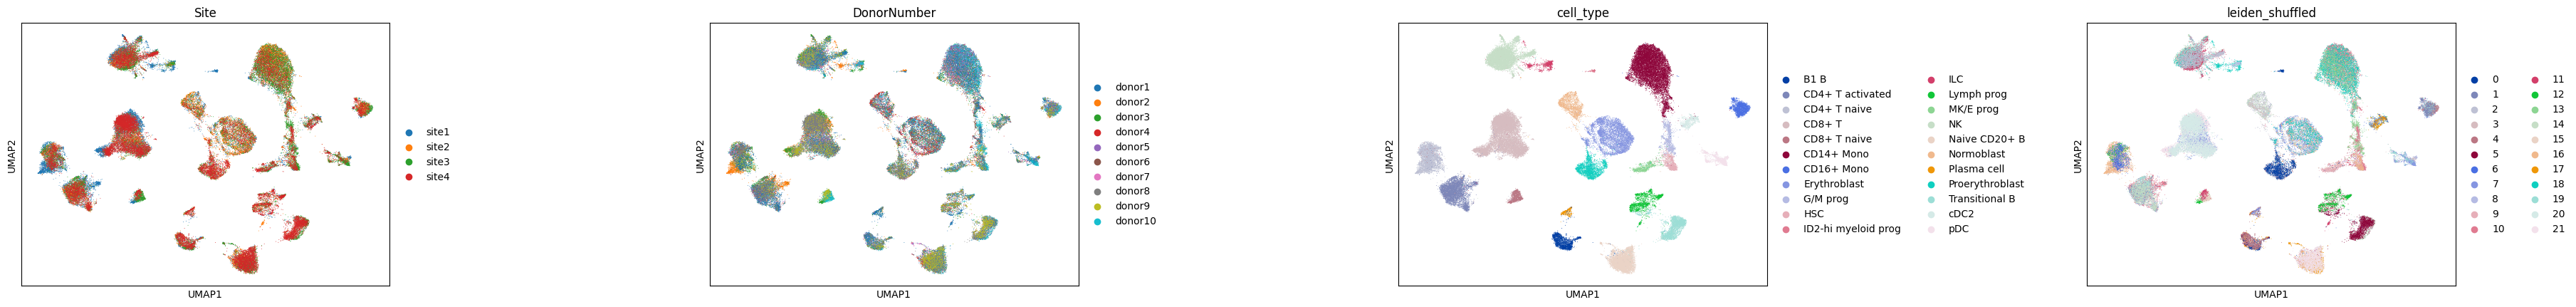

In [4]:
sc.pl.embedding(adata, basis="umap", color=["Site", "DonorNumber", "cell_type", "leiden_shuffled"], wspace=0.7, ncols=5)

We're using the `Site` annotation to denote different samples, and we randomly shuffled the order of cluster labels within each sample to resemble a realistic scenario, in which we're given a dataset with several samples, with independent clustering per sample (i.e., pre-integration). 

## Query cell type labels per sample

In this notebook, we will demonstrate the slightly more advanced usage of this package, which involves a few method calls, but gives you more control and insights. 

If you're new and looking for the simplest way to get started, head over to our basic tutorial: {doc}`100_heart_atlas`. 

In [5]:
cell_ann = CellAnnotator(
    adata,
    species="human",
    tissue="bone marrow mononuclear cells",
    cluster_key="leiden_shuffled",
    sample_key="Site",
    model="gpt-4.1",
)

cell_ann

INFO     ✅ OPENAI API key is available                                                                            
INFO     Initializing `4` SampleAnnotator objects(s).                                                              


🧬 CellAnnotator
📋 Species: human
🔬 Tissue: bone marrow mononuclear cells
⏳ Stage: adult
🔗 Cluster key: leiden_shuffled
🔬 Sample key: Site

🤖 Provider: openai
🧠 Model: gpt-4.1

🔋 Status: ✅ Ready

📊 Samples: 4
🏷️  Sample IDs: 'site1', 'site2', 'site3', 'site4'

### Query expected cell types and actual markers

Let's start by querying expected cell types and their markers in this tissue. We can use this step as a validation, to see how much the model "knows" about our data. 

In [6]:
cell_ann.get_expected_cell_type_markers()

INFO     Querying cell types.                                                                                      
INFO     Writing expected cell types to `self.expected_cell_types`                                                 
INFO     Querying cell type markers.                                                                               
INFO     Writing expected marker genes to `self.expected_marker_genes`.                                            
INFO     Filtering marker genes to only include those present in adata.var_names.                                  
INFO     Filtered 9 marker genes and removed 0 cell types with no marker genes left after filtering.               


Let's take a look at these. 

In [7]:
cell_ann.expected_marker_genes

{'Hematopoietic stem cell (HSC)': ['CD34', 'PROM1', 'MEIS1', 'ITGA6', 'SPI1'],
 'Multipotent progenitor (MPP)': ['CD34', 'PROM1', 'MEIS1', 'SPI1', 'MYB'],
 'Common myeloid progenitor (CMP)': ['CD34', 'MEIS1', 'SPI1', 'MYB', 'GATA2'],
 'Granulocyte-monocyte progenitor (GMP)': ['CD34',
  'SPI1',
  'MYB',
  'MNDA',
  'GFI1'],
 'Megakaryocyte-erythroid progenitor (MEP)': ['CD34',
  'GATA1',
  'KLF1',
  'GATA2',
  'EPOR'],
 'Common lymphoid progenitor (CLP)': ['CD34', 'EBF1', 'IL7R', 'MYB', 'TCF3'],
 'Monocyte': ['MNDA', 'LYZ', 'FCGR2A', 'FCGR3A', 'CD14'],
 'Macrophage': ['CD68', 'CSF1R', 'FCGR3A', 'CD163'],
 'Granulocytes (Neutrophil, Basophil, Eosinophil precursors)': ['CSF3R',
  'LYZ',
  'MPO',
  'AZU1',
  'CFD'],
 'Dendritic cell precursors': ['CD74', 'IRF8', 'SPI1', 'HLA-DRA', 'CD83'],
 'B cell progenitors (Pro-B, Pre-B, immature B cells)': ['EBF1',
  'PAX5',
  'CD19',
  'CD79B',
  'MYB'],
 'Mature B cell': ['CD19', 'CD79B', 'MS4A1', 'IGHM', 'IGHD'],
 'T cell progenitors (mainly at ear

Ok, that looks reasonable. We could modify these expected cell types and marker genes by providing a dictionary and overwriting `CellAnnotator.expected_marker_genes`, thereby infusing prior knowledge. This information will be used later on to guide cell type label querying. 

In the next step, we'll compute marker genes for the clusters in our dataset. 


In [8]:
cell_ann.get_cluster_markers()

INFO     Iterating over samples to compute cluster marker genes.                                                   


  0%|          | 0/4 [00:00<?, ?it/s]

/Users/mlange/miniforge3/envs/cell_annotator/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:479: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/mlange/miniforge3/envs/cell_annotator/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:479: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/mlange/miniforge3/envs/cell_annotator/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:479: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/mlange/miniforge3/envs/cell_annotator/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:479: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


We can also take a look at these marker genes. Under the hood, we created once {class}`cell_annotator.SampleAnnotator` class per sample, and marker genes are written into these. Let's take a look at an example: 

In [9]:
cell_ann.sample_annotators["site3"].marker_gene_dfs["0"].head()

,gene,specificity,auc
0,BANK1,0.803347,0.969336
1,RALGPS2,0.754415,0.943715
2,OSBPL10,0.932700,0.881645
3,MS4A1,0.917240,0.880816
4,EBF1,0.842919,0.845968


These are the top marker genes for one cluster in one sample. 

### Annotate clusters

Using the marker genes computed above, we can now query the model for cell type labels. The expected cell types and marker genes queried above help to make predictions more robust and consistent across samples. 

In [10]:
cell_ann.annotate_clusters()

INFO     Iterating over samples to annotate clusters.                                                              


  0%|          | 0/4 [00:00<?, ?it/s]

WARNING  Not enough markers provided for cluster 0 in sample `site1` (0<2).                                        
WARNING  Not enough markers provided for cluster 10 in sample `site1` (1<2).                                       
WARNING  Not enough markers provided for cluster 18 in sample `site1` (0<2).                                       
WARNING  Not enough markers provided for cluster 8 in sample `site3` (0<2).                                        
WARNING  Not enough markers provided for cluster 14 in sample `site4` (1<2).                                       
INFO     Querying cell-type label de-duplication.                                                                  
INFO     Removed 14/35 cell types.                                                                                 
INFO     Iterating over samples to harmonize cell type annotations.                                                


  0%|          | 0/4 [00:00<?, ?it/s]

INFO     Writing updated cluster labels to `adata.obs[`cell_type_predicted'].                                      


🧬 CellAnnotator
📋 Species: human
🔬 Tissue: bone marrow mononuclear cells
⏳ Stage: adult
🔗 Cluster key: leiden_shuffled
🔬 Sample key: Site

🤖 Provider: openai
🧠 Model: gpt-4.1

🔋 Status: ✅ Ready

📊 Samples: 4
🏷️  Sample IDs: 'site1', 'site2', 'site3', 'site4'

Within each {class}`cell_annotator.SampleAnnotator`, we can inspect annotation results: 

In [11]:
cell_ann.sample_annotators["site3"].annotation_df.head(10)

,n_cells,marker_genes,reason_for_failure,marker_gene_description,cell_type,cell_state,annotation_confidence,reason_for_confidence_estimate,cell_type_harmonized
0,455,"BANK1, RALGPS2, OSBPL10, MS4A1, EBF1, BLK, PAX5",None,"BANK1, MS4A1, EBF1, BLK, and PAX5 are classic ...",Mature B cell,Normal,High,The cluster expresses multiple highly specific...,Mature B cell
1,356,"NFIA, SLC25A21, KIAA1211, ANK1, MBOAT2, CDC42B...",None,ANK1 is a marker of erythroid lineage and is f...,Erythroid precursor,Normal,Medium,The presence of ANK1 and supporting erythroid-...,Erythroid precursor
2,213,"SLC4A1, TSPAN5, ANK1, SLC25A37, SOX6, SPTA1, M...",None,"SLC4A1, ANK1, SPTA1, and SLC25A37 are classic ...",Erythroid precursor,Normal,High,The cluster expresses highly specific markers ...,Erythroid precursor
3,258,"ZNF385D, XACT, KIAA1211, MED12L, TAFA2, RYR3, ...",None,"Cluster 3 exhibits a set of markers (ZNF385D, ...",Unknown,Normal,Low,Markers do not match canonical bone marrow cel...,Unknown
4,353,"TCF7L2, MTSS1, WARS, PECAM1, MS4A7, RNF144B, C...",None,PECAM1 is a classic endothelial cell marker. T...,Endothelial cell,Normal,High,Strong identification based on classical endot...,Endothelial cell
5,38,"IFNG-AS1, MZB1, TXNDC5, DENND5B, SEL1L3, AL589...",None,MZB1 is strongly associated with plasma cells ...,Plasma cell,Normal,High,"MZB1 is a well-established plasma cell marker,...",Plasma cell
6,248,"NEGR1, CST3, CCSER1, RUNX2, HLA-DPB1, FLT3, CIITA",None,The markers in this cluster include FLT3 and H...,Dendritic cell precursor (or multipotent proge...,Normal,Medium,The presence of FLT3 and HLA-DPB1 suggests a p...,Dendritic cell precursor
7,623,"APP, AC023590.1, RUNX2, FAM160A1, PLXNA4, CUX2...",None,"The markers for cluster 7 are APP, AC023590.1,...",Unknown,Normal,Low,None of the markers for this cluster match can...,Unknown
8,129,,Not enough markers provided for cluster 8 in s...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
9,581,"CAMK4, BCL11B, INPP4B, LEF1, ANK3, IL7R, MLLT3",None,"CAMK4, BCL11B, and LEF1 are core transcription...",T cell progenitor,Normal,High,"Multiple markers (CAMK4, BCL11B, LEF1, IL7R) a...",T cell progenitor


You can see that the model returns `Unknown` when the provided information isn't enough to output a reliable prediction.  

Annotations have been automatically harmonized across samples (`cell_type_harmonized`) and written to the underling {class}`anndata.AnnData` object, by default to `cell_type_predicted`. 

### Evaluate

First, let's get clusters into a consistent ordering across annotations. This will make it easier to interpret the results in a confusion matrix. 

In [12]:
cell_ann.reorder_and_color_clusters(keys=["cell_type", "cell_type_predicted"], assign_colors=True)

INFO     Querying label ordering.                                                                                  
INFO     Querying cluster colors.                                                                                  
INFO     Writing categories for key 'cell_type'                                                                    
INFO     Writing categories for key 'cell_type_predicted'                                                          


Compute ground-truth with predicted cell type labels in a confusion matrix (across all samples). 

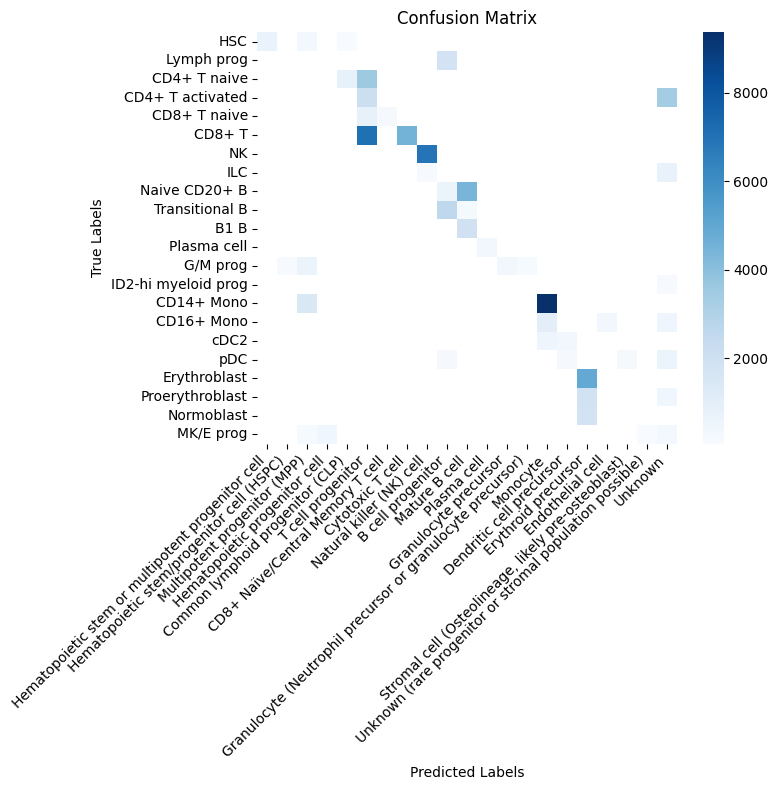

In [13]:
df = adata.obs.groupby(["cell_type", "cell_type_predicted"], observed=True).size().unstack()

# Plot the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(df, annot=False, cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We can also compare ground-truth and predicted cell types in the UMAP embedding. 

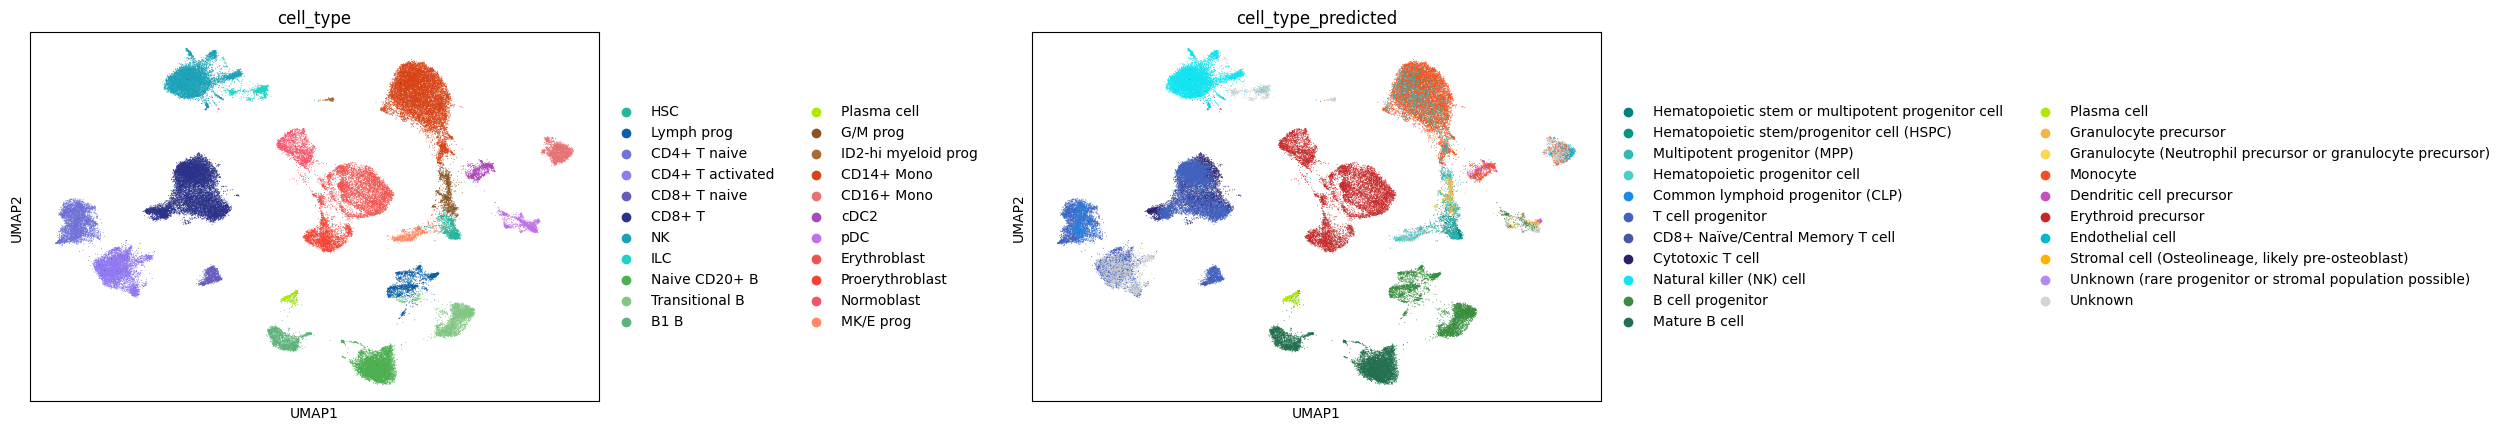

In [14]:
sc.pl.embedding(adata, basis="umap", color=["cell_type", "cell_type_predicted"], wspace=0.6)